# Deep Agent - Langchain's Multi-Agent Deep Researcher

Advanced financial research system using LangChain's DeepAgent with context isolation and strategic delegation.

https://docs.langchain.com/oss/python/deepagents/harness

## Overview

This notebook demonstrates:
- **DeepAgent Framework**: LangChain's advanced agent architecture
- **Context Isolation**: Sub-agents with isolated contexts for focused research
- **Strategic Delegation**: Orchestrator coordinates multiple specialist sub-agents
- **RAG + Live Data**: Hybrid search on SEC filings + Yahoo Finance integration
- **File-Based Memory**: Persistent research artifacts with secure sandbox (virtual_mode=True)

**Key Features:**
1. Orchestrator breaks down complex queries into research tasks
2. Sub-agents conduct focused research with isolated context
3. Think tool for strategic reflection and decision-making
4. Final report synthesis with consolidated citations
5. SQLite checkpointer for conversation memory
6. FilesystemBackend with virtual_mode for secure file operations

## Setup

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from dotenv import load_dotenv
load_dotenv()

True

In [3]:
import os
import sqlite3
from datetime import datetime

from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.checkpoint.sqlite import SqliteSaver

from scripts.rag_tools import hybrid_search, live_finance_researcher, think_tool

from deepagents import create_deep_agent
from deepagents.backends import FilesystemBackend

from scripts.deep_prompts import DEEP_RESEARCHER_INSTRUCTIONS, DEEP_ORCHESTRATOR_INSTRUCTIONS

## Initialize Memory and File Backend

In [4]:
# Secure filesystem backend for research outputs
RESEARCH_OUTPUT_DIR = os.path.join(os.getcwd(),"research_outputs")

In [5]:
def get_research_backend(user_id, thread_id):

    USER_OUTPUT_DIR = os.path.join(RESEARCH_OUTPUT_DIR, user_id, thread_id)
    
    os.makedirs(USER_OUTPUT_DIR, exist_ok=True)

    print(f"Writing research files to: {USER_OUTPUT_DIR}")

    # Create filesystem backend with virtual_mode=True for security
    backend = FilesystemBackend(
        root_dir=USER_OUTPUT_DIR,
        virtual_mode=True  # Prevents agent from accessing files outside sandbox
    )

    return backend

## Create Research Sub-Agent

In [6]:
# Get current date
current_date = datetime.now().strftime("%Y-%m-%d")

# Create research sub-agent with isolated context
research_sub_agent = {
    "name": "financial-research-agent",
    "description": "Delegate financial research to this sub-agent. Give it one specific research task at a time.",
    "system_prompt": DEEP_RESEARCHER_INSTRUCTIONS.format(date=current_date),
    "tools": [hybrid_search, live_finance_researcher, think_tool],
}

## Initialize LLM and Create DeepAgent

In [7]:
# Initialize model
model = ChatGoogleGenerativeAI(model='gemini-3-flash-preview')

# Tools for the main agent (orchestrator level)
tools = [hybrid_search, live_finance_researcher, think_tool]

In [8]:
def get_deep_agent(user_id, thread_id):

    # SQLite checkpointer for agent memory
    conn = sqlite3.connect('data/deep_agent_finance_researcher.db', check_same_thread=False)
    checkpointer = SqliteSaver(conn=conn)

    backend = get_research_backend(user_id, thread_id)

    # Create the deep agent with memory and secure file backend
    agent = create_deep_agent(
        model=model,
        tools=tools,
        system_prompt=DEEP_ORCHESTRATOR_INSTRUCTIONS,
        subagents=[research_sub_agent],
        checkpointer=checkpointer,  # SQLite memory
        backend=backend,  # Secure filesystem with virtual_mode=True
    )

    return agent



In [9]:
user_id = 'kgptalkie'
thread_id = 'sessions1'
agent = get_deep_agent(user_id, thread_id)

Writing research files to: d:\Courses\Udemy\Multi Agent Deep RAG\research_outputs\kgptalkie\sessions1


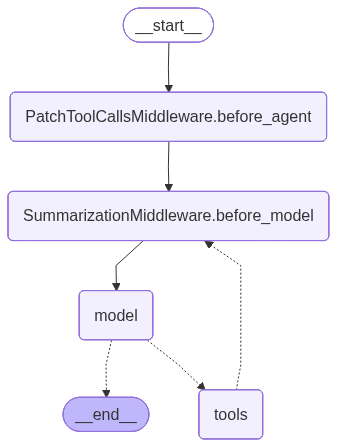

In [10]:
agent

## Examples

In [11]:
from scripts.agent_utils import stream_agent_response

query = "What was Amazon's revenue in Q1 2024?"
user_id = "kgptalkie"
thread_id="session1"

agent = get_deep_agent(user_id, thread_id)
stream_agent_response(agent, query, thread_id)

Writing research files to: d:\Courses\Udemy\Multi Agent Deep RAG\research_outputs\kgptalkie\session1

  Tool Called: write_todos
   Args: {'todos': [{'status': 'in_progress', 'content': 'Save research request to /research_request.md'}, {'status': 'pending', 'content': "Research Amazon's Q1 2024 revenue using a sub-agent"}, {'status': 'pending', 'content': 'Synthesize findings and write final report to /final_report.md'}, {'status': 'pending', 'content': 'Verify and conclude research'}]}


  Tool Called: write_file
   Args: {'file_path': '/research_request.md', 'content': "What was Amazon's revenue in Q1 2024?"}


  Tool Result (length: 363 chars)


  Tool Result (length: 33 chars)


  Tool Called: write_todos
   Args: {'todos': [{'status': 'completed', 'content': 'Save research request to /research_request.md'}, {'status': 'in_progress', 'content': "Research Amazon's Q1 2024 revenue using a sub-agent"}, {'status': 'pending', 'content': 'Synthesize findings and write final report to /fi

In [12]:
query = "Compare Apple and Amazon's 2024 revenue and profitability. Present full and detailed report."
thread_id="session2"

agent = get_deep_agent(user_id, thread_id)
stream_agent_response(agent, query, thread_id)

Writing research files to: d:\Courses\Udemy\Multi Agent Deep RAG\research_outputs\kgptalkie\session2

  Tool Called: write_file
   Args: {'file_path': '/research_request.md', 'content': "Compare Apple and Amazon's 2024 revenue and profitability. Present full and detailed report."}


  Tool Called: write_todos
   Args: {'todos': [{'status': 'completed', 'content': 'Save research request to /research_request.md'}, {'status': 'in_progress', 'content': "Research Apple's 2024 revenue and profitability metrics"}, {'status': 'in_progress', 'content': "Research Amazon's 2024 revenue and profitability metrics"}, {'status': 'pending', 'content': 'Synthesize findings and consolidate citations'}, {'status': 'pending', 'content': 'Write final report to /final_report.md'}, {'status': 'pending', 'content': 'Verify report against original request'}]}


  Tool Called: task
   Args: {'description': "Research Apple's financial performance for fiscal year 2024 (ending September 2024). \nFocus on:\n- Total